# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: Surya Giri
### CWID: 10475010


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import tensorflow as tf
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))


shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
  coded = np.zeros((len(y), num_class))
  for i, y in enumerate(y):
    coded[i, y] = 1
  return coded

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
from keras.layers import Dense
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models, layers

model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64,(4,4), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))



In [5]:
# Checking if the model is built correctly
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [6]:
# Define model optimizer and loss function
from keras import optimizers
model_cnn.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model and store model parameters/loss values
history = model_cnn.fit(x_tr, y_tr, batch_size=16, epochs=200, validation_data=(x_val, y_val))

Epoch 1/200
2500/2500 [==============================] - 8s 2ms/step - loss: 14.8967 - accuracy: 0.1391 - val_loss: 9.7571 - val_accuracy: 0.1642
Epoch 2/200
2500/2500 [==============================] - 4s 2ms/step - loss: 8.4726 - accuracy: 0.1778 - val_loss: 7.6083 - val_accuracy: 0.1844
Epoch 3/200
2500/2500 [==============================] - 4s 2ms/step - loss: 6.9351 - accuracy: 0.2019 - val_loss: 6.5022 - val_accuracy: 0.2123
Epoch 4/200
2500/2500 [==============================] - 4s 2ms/step - loss: 6.0374 - accuracy: 0.2209 - val_loss: 5.8066 - val_accuracy: 0.2264
Epoch 5/200
2500/2500 [==============================] - 4s 2ms/step - loss: 5.4431 - accuracy: 0.2370 - val_loss: 5.2867 - val_accuracy: 0.2393
Epoch 6/200
2500/2500 [==============================] - 4s 2ms/step - loss: 5.0073 - accuracy: 0.2500 - val_loss: 4.9322 - val_accuracy: 0.2428
Epoch 7/200
2500/2500 [==============================] - 4s 2ms/step - loss: 4.6688 - accuracy: 0.2601 - val_loss: 4.6263 - val_a

## 3. Plot the training and validation loss curve versus epochs. (5 points)

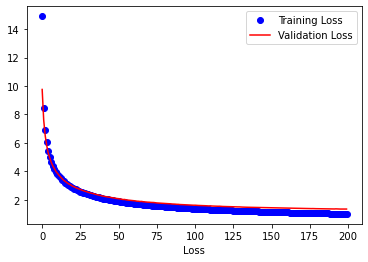

In [8]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(200)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()


## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [9]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
from keras import optimizers
model_cnn.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Evaluate your model performance (testing accuracy) on testing data.
history = model_cnn.fit(x_train, y_train_vec, batch_size=16, epochs=200, validation_data = (x_test, y_test_vec))

Epoch 1/200
3125/3125 [==============================] - 6s 2ms/step - loss: 1.0849 - accuracy: 0.6387 - val_loss: 1.3425 - val_accuracy: 0.5675
Epoch 2/200
3125/3125 [==============================] - 5s 2ms/step - loss: 1.0812 - accuracy: 0.6399 - val_loss: 1.3430 - val_accuracy: 0.5680
Epoch 3/200
3125/3125 [==============================] - 5s 2ms/step - loss: 1.0774 - accuracy: 0.6417 - val_loss: 1.3340 - val_accuracy: 0.5687
Epoch 4/200
3125/3125 [==============================] - 6s 2ms/step - loss: 1.0744 - accuracy: 0.6425 - val_loss: 1.3344 - val_accuracy: 0.5680
Epoch 5/200
3125/3125 [==============================] - 5s 2ms/step - loss: 1.0709 - accuracy: 0.6430 - val_loss: 1.3368 - val_accuracy: 0.5660
Epoch 6/200
3125/3125 [==============================] - 6s 2ms/step - loss: 1.0682 - accuracy: 0.6438 - val_loss: 1.3296 - val_accuracy: 0.5727
Epoch 7/200
3125/3125 [==============================] - 5s 2ms/step - loss: 1.0643 - accuracy: 0.6460 - val_loss: 1.3337 - val_ac

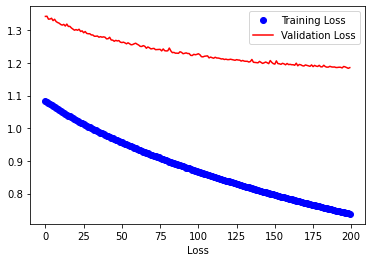

In [11]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(200)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [12]:
modvar = model_cnn.evaluate(x_test, y_test_vec)
print('loss = ' + str(modvar[0]))
print('accuracy = ' + str(modvar[1]))

313/313 [==============================] - 1s 1ms/step - loss: 1.1856 - accuracy: 0.6245
loss = 1.1856324672698975
accuracy = 0.6244999766349792


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

## 6.1. Model 1

In [13]:
from keras.layers import Dense
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models, layers

# Build the network
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64,(4,4), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dropout(0.3))
model_cnn.add(layers.Dense(10, activation='softmax'))

# Define model optimizer and loss function
from keras import optimizers
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_tr, y_tr, batch_size=256, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 2s 7ms/step - loss: 3.6486 - accuracy: 0.2314 - val_loss: 1.9772 - val_accuracy: 0.2675
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 1.8793 - accuracy: 0.3239 - val_loss: 1.7669 - val_accuracy: 0.3791
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7732 - accuracy: 0.3647 - val_loss: 1.7049 - val_accuracy: 0.3952
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6933 - accuracy: 0.3914 - val_loss: 1.6116 - val_accuracy: 0.4333
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6460 - accuracy: 0.4128 - val_loss: 1.6012 - val_accuracy: 0.4229
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6031 - accuracy: 0.4276 - val_loss: 1.5572 - val_accuracy: 0.4468
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.5740 - accuracy: 0.4367 - val_loss: 1.5000 - val_accuracy: 0.4675
Epoch 

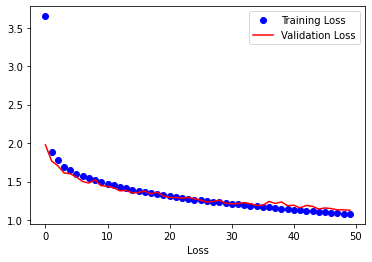

In [14]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

### Evaluate with Test Set

In [15]:
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_train, y_train_vec, batch_size=256, epochs=50, validation_data = (x_test, y_test_vec))

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.2955 - accuracy: 0.1040 - val_loss: 2.3002 - val_accuracy: 0.1000
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 2.2940 - accuracy: 0.1042 - val_loss: 2.2774 - val_accuracy: 0.1324
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 2.2127 - accuracy: 0.1540 - val_loss: 2.1569 - val_accuracy: 0.1706
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 2.0949 - accuracy: 0.2083 - val_loss: 2.0403 - val_accuracy: 0.2451
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 2.0369 - accuracy: 0.2395 - val_loss: 2.0130 - val_accuracy: 0.2517
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9997 - accuracy: 0.2573 - val_loss: 1.9597 - val_accuracy: 0.2793
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 1.9574 - accuracy: 0.2776 - val_loss: 1.9436 - val_accuracy: 0.2791
Epoch 

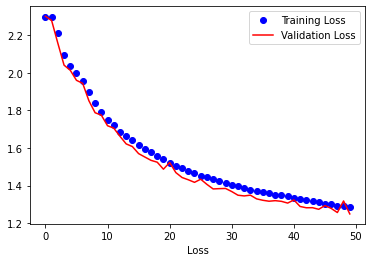

In [16]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

## 6.2. Model 2

In [17]:
from keras.layers import Dense
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models, layers

# Build the network
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64,(4,4), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dropout(0.3))
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

# Define model optimizer and loss function
from keras import optimizers
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_tr, y_tr, batch_size=256, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 2s 7ms/step - loss: 3.0316 - accuracy: 0.2910 - val_loss: 1.7132 - val_accuracy: 0.3972
Epoch 2/50
157/157 [==============================] - 1s 6ms/step - loss: 1.6809 - accuracy: 0.4047 - val_loss: 1.6688 - val_accuracy: 0.3862
Epoch 3/50
157/157 [==============================] - 1s 6ms/step - loss: 1.5657 - accuracy: 0.4449 - val_loss: 1.5960 - val_accuracy: 0.4261
Epoch 4/50
157/157 [==============================] - 1s 6ms/step - loss: 1.4882 - accuracy: 0.4729 - val_loss: 1.4221 - val_accuracy: 0.5006
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.4299 - accuracy: 0.4953 - val_loss: 1.4337 - val_accuracy: 0.4845
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3961 - accuracy: 0.5082 - val_loss: 1.3677 - val_accuracy: 0.5132
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3595 - accuracy: 0.5227 - val_loss: 1.4488 - val_accuracy: 0.4909
Epoch 

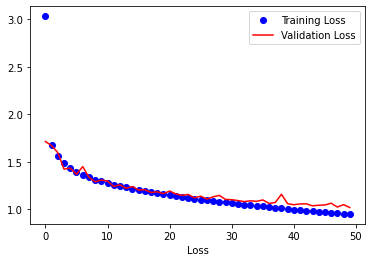

In [18]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

### Evaluate with Test Set

In [19]:
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_train, y_train_vec, batch_size=256, epochs=50, validation_data = (x_test, y_test_vec))

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.2952 - accuracy: 0.1020 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.1016 - val_loss: 2.3026 - val_accuracy: 0.0990
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.0995
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.0997
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.1049 - val_loss: 2.3026 - val_accuracy: 0.0997
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.1019 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.0999 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 

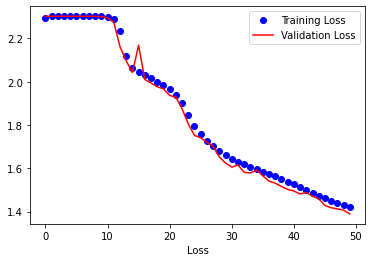

In [20]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

## 6.3. Model 3

In [21]:
from keras.layers import Dense
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models, layers

# Build the network
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Conv2D(64,(4,4), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

# Define model optimizer and loss function
from keras import optimizers
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_tr, y_tr, batch_size=256, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 1s 7ms/step - loss: 5.4296 - accuracy: 0.1515 - val_loss: 2.2143 - val_accuracy: 0.1584
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 2.1385 - accuracy: 0.2131 - val_loss: 2.3760 - val_accuracy: 0.1146
Epoch 3/50
157/157 [==============================] - 1s 6ms/step - loss: 2.0201 - accuracy: 0.2659 - val_loss: 2.3518 - val_accuracy: 0.1428
Epoch 4/50
157/157 [==============================] - 1s 6ms/step - loss: 1.9244 - accuracy: 0.3073 - val_loss: 2.3389 - val_accuracy: 0.1774
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 1.8493 - accuracy: 0.3329 - val_loss: 2.0890 - val_accuracy: 0.2449
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7940 - accuracy: 0.3557 - val_loss: 1.9538 - val_accuracy: 0.2918
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 1.7515 - accuracy: 0.3650 - val_loss: 1.8033 - val_accuracy: 0.3526
Epoch 

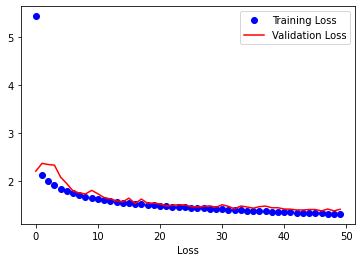

In [22]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

### Evaluate with Test Set

In [23]:
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_train, y_train_vec, batch_size=256, epochs=50, validation_data = (x_test, y_test_vec))

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.2977 - accuracy: 0.1032 - val_loss: 2.3025 - val_accuracy: 0.1063
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.1065 - val_loss: 2.3025 - val_accuracy: 0.1001
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1021 - val_loss: 2.3022 - val_accuracy: 0.1207
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3016 - accuracy: 0.1024 - val_loss: 2.3006 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 2.2937 - accuracy: 0.1001 - val_loss: 2.2782 - val_accuracy: 0.1008
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 2.2234 - accuracy: 0.1391 - val_loss: 2.1665 - val_accuracy: 0.1863
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 2.0888 - accuracy: 0.2060 - val_loss: 2.0508 - val_accuracy: 0.2337
Epoch 

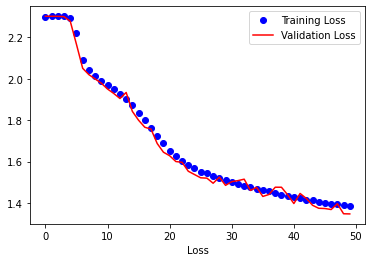

In [24]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

## 6.4. Model 4

In [25]:
from keras.layers import Dense
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import models, layers

# Build the network
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Conv2D(64,(4,4), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Dense(10, activation='softmax'))

# Define model optimizer and loss function
from keras import optimizers
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_tr, y_tr, batch_size=256, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
157/157 [==============================] - 2s 7ms/step - loss: 3.9939 - accuracy: 0.1728 - val_loss: 2.1619 - val_accuracy: 0.1534
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 2.0255 - accuracy: 0.2519 - val_loss: 2.0291 - val_accuracy: 0.2517
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 1.9426 - accuracy: 0.2903 - val_loss: 1.9300 - val_accuracy: 0.2839
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.8833 - accuracy: 0.3166 - val_loss: 1.9494 - val_accuracy: 0.2786
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 1.8313 - accuracy: 0.3391 - val_loss: 1.8844 - val_accuracy: 0.3135
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7843 - accuracy: 0.3544 - val_loss: 1.8415 - val_accuracy: 0.3163
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 1.7456 - accuracy: 0.3703 - val_loss: 1.7628 - val_accuracy: 0.3572
Epoch 

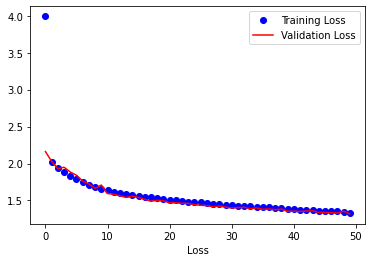

In [26]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(50)
train_acc = history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

### Evaluate with Test Set

In [27]:
model_cnn.compile(optimizer='Ftrl', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store model parameters/loss values
history = model_cnn.fit(x_train, y_train_vec, batch_size=256, epochs=100, validation_data = (x_test, y_test_vec))

Epoch 1/100
196/196 [==============================] - 2s 6ms/step - loss: 2.2975 - accuracy: 0.1011 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
196/196 [==============================] - 1s 6ms/step - loss: 2.3026 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
196/196 [==============================] - 1s 5ms/step - loss: 2.3026 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.1000

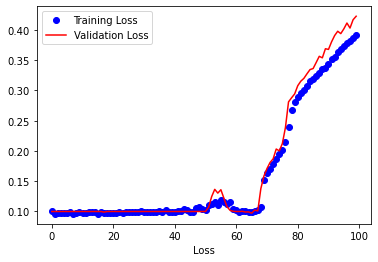

In [28]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(100)
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training Loss')
plt.plot(epochs, valid_acc, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()